In [1]:
import BudykoSellers
import emulator_utils
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use a LaTeX-compatible serif font
    "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
})

%load_ext autoreload
%autoreload 2

## Toy to test solving for heat capacity, feedback parameter, and diffusivity from data

# Experiment 1: 3-box model
Note for this problem that the true values for the parameters are:

C = [190.129, 1.268, 19.013]

$\lambda$ = [0.67, 0.86, 2.0]

K = [0.55] (If diffusivity is turned on)

One thing to note before getting into this: if I repeat this exercise with the symmetric 5 box model with no knowledge about the structure of the problem, then DMD struggles to find the correct solution due to the symmetry of the problem (I can elaborate more on this if needed, but the TL;DR is most apparent in the uncoupled case, where the symmetry means that $A$ has non-zero entries in the symmetric indices, such as $A_{1,1} = A_{1,5}$).

TL;DR: Even if we impose the correct matrix structure, once we incorporate diffusion this linear regression-type methodology breaks down. I know you can get clever and solve for different terms sequentially like Paolo did, but I'm not sure how extendible that is to a full-scale system.

In [75]:
out_Abrupt_Uncoup, out_Abrupt_Coup = BudykoSellers.Run_Budyko_Sellers(exp_flag=0, n_boxes=3), BudykoSellers.Run_Budyko_Sellers(exp_flag=0, diff_flag=1, n_boxes=3)
T_Abrupt_Uncoup, T_Abrupt_Coup = np.squeeze(out_Abrupt_Uncoup['T_ts']), np.squeeze(out_Abrupt_Coup['T_ts'])

/Users/chriswomack/Documents/PhD/Project 1/BudykoSellers.py:308: UserWarning: Simulation has not reached equilibirum (diseq > 1e-3 W m-2)
  warnings.warn('Simulation has not reached equilibirum (diseq > 1e-3 W m-2)')


/Users/chriswomack/Documents/PhD/Project 1/BudykoSellers.py:424: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  


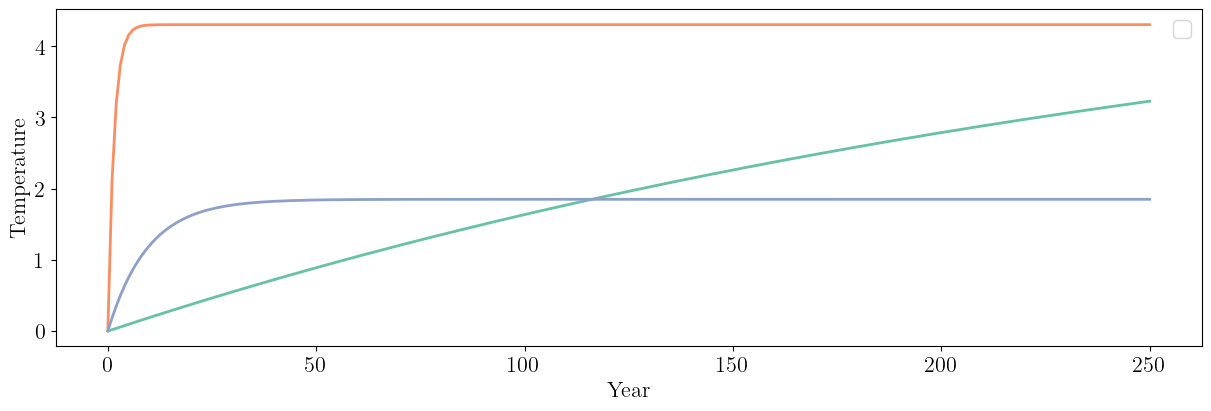

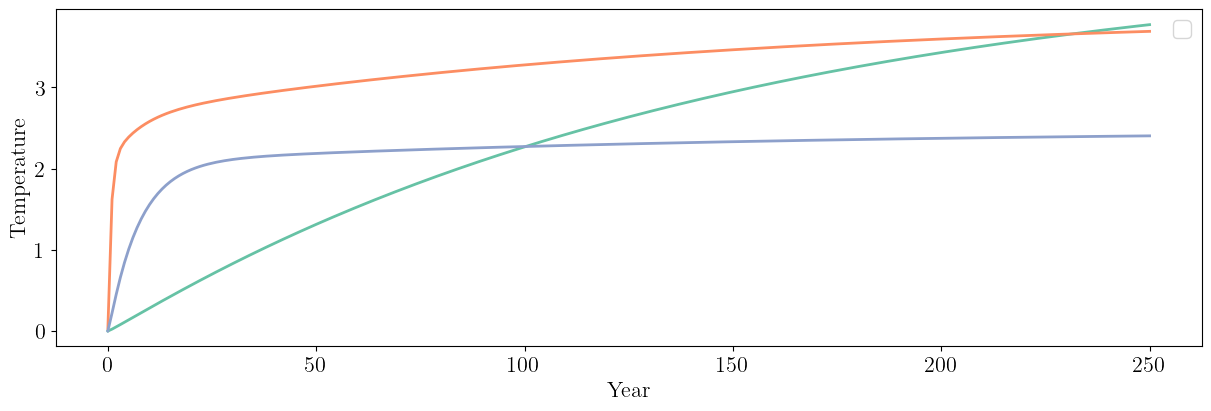

In [76]:
BudykoSellers.plot_BudykoSellers(out_Abrupt_Uncoup)
BudykoSellers.plot_BudykoSellers(out_Abrupt_Coup)

## 1) Basic DMDc
With no additional information, DMDc is simply the least squares solution to the system: $\frac{\partial T(x,t)}{\partial t} = A(x,x) T(x,t) + B(x,x) F(x,t)$, solving for $A, \, B$.

The main thing to note here is that this is solving the most general version of the problem - this may not be physical, but it "works" mathematically.

### 1a) Uncoupled system

In [77]:
F = 3.7*np.ones((3,251))
A_DMD_Uncoup, B_DMD_Uncoup = emulator_utils.method_1a_DMD(np.squeeze(T_Abrupt_Uncoup), F)

In [78]:
A_DMD_Uncoup, B_DMD_Uncoup

(array([[ 9.96495251e-01,  4.68396718e-05, -1.84558101e-05],
        [ 7.87686465e-05,  5.10857252e-01, -1.40928175e-03],
        [ 9.32093930e-06,  4.23238198e-04,  9.00254611e-01]]),
 array([[0.00172887, 0.00172887, 0.00172887],
        [0.18980797, 0.18980797, 0.18980797],
        [0.01645816, 0.01645816, 0.01645816]]))

In [79]:
C_Uncoup, lam_Uncoup = [], []
for i in range(len(B_DMD_Uncoup)):
  C_Uncoup.append(1/np.sum(B_DMD_Uncoup[i]))
  lam_Uncoup.append(-(A_DMD_Uncoup[i,i] - 1)*C_Uncoup[i]) # Note the factor of 1 we have to subtract from the Forward Euler scheme

For the uncoupled system, the algorithm is somewhat able to recognize that the matrix $A$ should be sparse. But it's not able to do so with $B$. Interestingly, the forcing component into each box is the same, if we take the sum over each row, we get back an approximation for the heat capacity. We can then use this to solve for the feedback parameters, which are also close to the true values.

In [80]:
C_Uncoup, lam_Uncoup

([np.float64(192.8046068650234),
  np.float64(1.7561608985431458),
  np.float64(20.25337867981256)],
 [np.float64(0.6757316707938108),
  np.float64(0.8590133677164555),
  np.float64(2.0201811284384643)])

And finally, using this solution to emulate the true system.

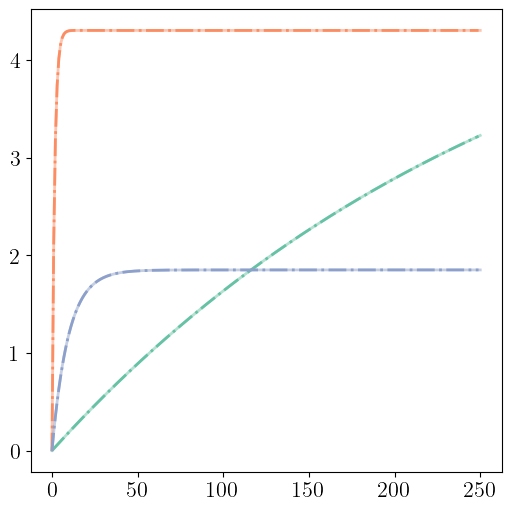

In [82]:
w0 = np.zeros(3)
n_steps = 250
T_pred_DMD_Uncoup = emulator_utils.emulate_DMD(F, A_DMD_Uncoup, B_DMD_Uncoup, w0, n_steps)

def plot_true_pred(T_true, T_pred):
  fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True)
  n_boxes = T_true.shape[0]
  for k in range(n_boxes):
    ax.plot(T_true[k,:], lw=2, c=emulator_utils.brewer2_light(k), alpha=0.5)
    ax.plot(T_pred[k,:], lw=2, c=emulator_utils.brewer2_light(k), ls='-.')

  return

plot_true_pred(T_Abrupt_Uncoup, T_pred_DMD_Uncoup)

### 1b) Coupled system

In [65]:
F = 3.7*np.ones((3,251))
A_DMD_Coup, B_DMD_Coup = emulator_utils.method_1a_DMD(np.squeeze(T_Abrupt_Coup), F)

In [93]:
A_DMD_Coup, B_DMD_Coup

(array([[9.92445606e-01, 2.64039212e-03, 4.34955257e-04],
        [1.85908754e-01, 2.62089195e-01, 1.70094526e-01],
        [4.57541932e-03, 2.41929390e-02, 8.64455063e-01]]),
 array([[0.0021138 , 0.0021138 , 0.0021138 ],
        [0.14549819, 0.14549819, 0.14549819],
        [0.01980364, 0.01980364, 0.01980364]]))

We'll follow much the same way as before, but go through it step by step. First, we try to calculate C as before:

In [90]:
C_Coup = []
for i in range(len(B_DMD_Coup)):
  C_Coup.append(1/np.sum(B_DMD_Coup[i]))

C_Coup

[np.float64(157.69398990830828),
 np.float64(2.2909792259399535),
 np.float64(16.831923754311717)]

Already we see the issue. Something about the diffusion makes the components of the ODE harder to distinguish with naive DMD, and our estimates for C are far off.

This propagates through the rest of the problem:

In [96]:
lam_Coup, gamma = [], []
for i in range(len(B_DMD_Coup)):
  if i < len(A_DMD_Coup) - 1:
    gamma.append(A_DMD_Coup[i,i+1]*C_Coup[i])
  else:
    gamma.append(A_DMD_Coup[i,i-1]*C_Coup[i])
  lam_Coup.append(-(A_DMD_Coup[i,i] + gamma[i]/C_Coup[i] - 1)*C_Coup[i]) # Note the factor of 1 we have to subtract from the Forward Euler scheme

gamma, lam_Coup

([np.float64(0.4163739687020544),
  np.float64(0.3896830245556356),
  np.float64(0.4072137047234794)],
 [np.float64(0.7749085634656584),
  np.float64(1.3008553013442448),
  np.float64(1.8742683436208578)])

The estimates aren't great, and we can see that we get an inconsistent answer for gamma depending on the index (though they're all in the same ballpark). The estimates are are worse, but they still kinda capture the overall behavior of the system in terms of the different timescales present.

We can still use this as an emulator though despite the inaccurate answer.

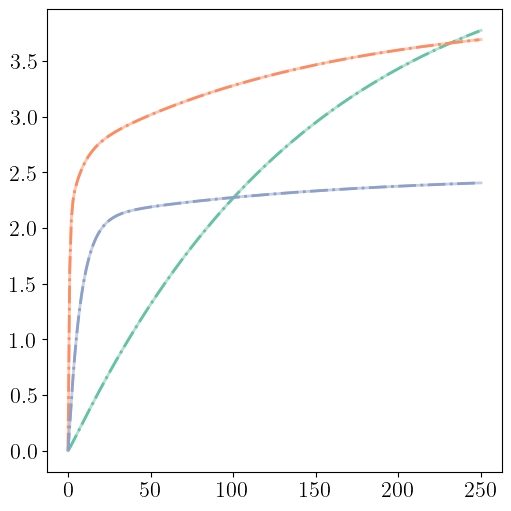

In [94]:
w0 = np.zeros(3)
n_steps = 250
T_pred_DMD_Coup = emulator_utils.emulate_DMD(F, A_DMD_Coup, B_DMD_Coup, w0, n_steps)
plot_true_pred(T_Abrupt_Coup, T_pred_DMD_Coup)

## 2) Incoporating structure into the DMDc algorithm

We'll still be looking at the same uncoupled and coupled 3-box model to start

### 2a) Uncoupled

In [100]:
F = 3.7*np.ones((3,251))
A_DMD_Uncoup, B_DMD_Uncoup = solve_structured_dmdc_bandedA_diagB(T_Abrupt_Uncoup[:,:-1], F[:,:-1], T_Abrupt_Uncoup[:,1:])

In [102]:
C_Uncoup, lam_Uncoup = [], []
for i in range(len(B_DMD_Uncoup)):
  C_Uncoup.append(1/np.sum(B_DMD_Uncoup[i]))
  lam_Uncoup.append(-(A_DMD_Uncoup[i,i] - 1)*C_Uncoup[i]) # Note the factor of 1 we have to subtract from the Forward Euler scheme

C_Uncoup, lam_Uncoup

([np.float64(192.6995666623538),
  np.float64(1.7561608985431547),
  np.float64(20.252608308148158)],
 [np.float64(0.6757452196731267),
  np.float64(0.8590133677164548),
  np.float64(2.019628683724946)])

We have a slightly better solution now, which would be even better if we enforced that all off-diagonal elements of $A$ are zero.

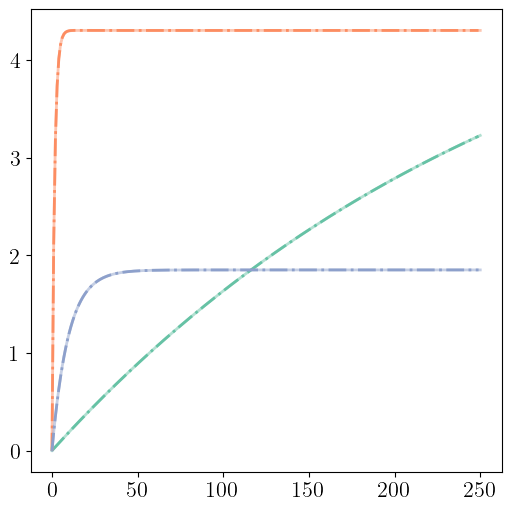

In [103]:
w0 = np.zeros(3)
n_steps = 250
T_pred_DMD_Uncoup = emulator_utils.emulate_DMD(F, A_DMD_Uncoup, B_DMD_Uncoup, w0, n_steps)
plot_true_pred(T_Abrupt_Uncoup, T_pred_DMD_Uncoup)

### 2b) Coupled

In [110]:
F = 3.7*np.ones((3,251))
A_DMD_Coup, B_DMD_Coup = solve_structured_dmdc_bandedA_diagB(T_Abrupt_Coup[:,:-1], F[:,:-1], T_Abrupt_Coup[:,1:])
A_DMD_Coup, B_DMD_Coup

(array([[0.99238788, 0.00309316, 0.        ],
        [0.18590875, 0.26208919, 0.17009453],
        [0.        , 0.03966571, 0.85832697]]),
 array([[0.00623779, 0.        , 0.        ],
        [0.        , 0.43649457, 0.        ],
        [0.        , 0.        , 0.0523118 ]]))

In [107]:
C_Coup = []
for i in range(len(B_DMD_Coup)):
  C_Coup.append(1/np.sum(B_DMD_Coup[i]))

C_Coup

[np.float64(160.3132931208586),
 np.float64(2.2909792259399953),
 np.float64(19.116147046704253)]

In [108]:
lam_Coup, gamma = [], []
for i in range(len(B_DMD_Coup)):
  if i < len(A_DMD_Coup) - 1:
    gamma.append(A_DMD_Coup[i,i+1]*C_Coup[i])
  else:
    gamma.append(A_DMD_Coup[i,i-1]*C_Coup[i])
  lam_Coup.append(-(A_DMD_Coup[i,i] + gamma[i]/C_Coup[i] - 1)*C_Coup[i]) # Note the factor of 1 we have to subtract from the Forward Euler scheme

gamma, lam_Coup

([np.float64(0.49587417693519414),
  np.float64(0.3896830245556279),
  np.float64(0.758255553183863)],
 [np.float64(0.7244493418619693),
  np.float64(1.3008553013442514),
  np.float64(1.9499868978507109)])

Our estimate for our third timescale has gotten better (in terms of both C and lambda), but none of our estimates of gamma are very good. However, we still have a great emulator.

Seems like the solution to this system isn't necessarily unique.

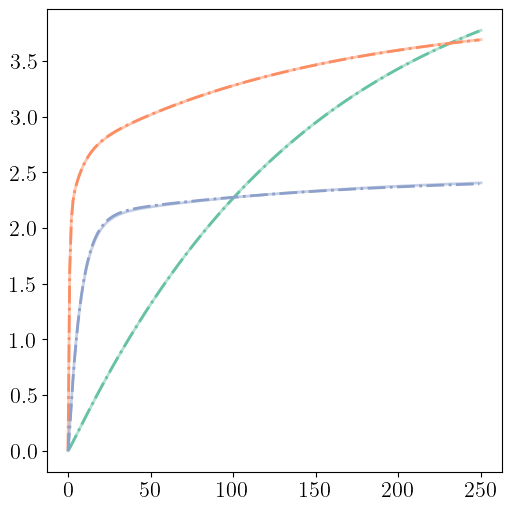

In [109]:
w0 = np.zeros(3)
n_steps = 250
T_pred_DMD_Coup = emulator_utils.emulate_DMD(F, A_DMD_Coup, B_DMD_Coup, w0, n_steps)
plot_true_pred(T_Abrupt_Coup, T_pred_DMD_Coup)

In [97]:
def solve_structured_dmdc_bandedA_diagB(X, F, Y):
    """
    Solve min || Y - A X - B F ||_F^2 subject to:
        A = [[a, b, 0],
             [c, d, e],
             [0, f, g]],
        B = diag([p, q, r]).

    Parameters
    ----------
    X : ndarray of shape (3, m)
        Current state snapshots (3D state).
    F : ndarray of shape (3, m)
        Input snapshots (3D input).
    Y : ndarray of shape (3, m)
        Next state snapshots (3D state).

    Returns
    -------
    A : ndarray of shape (3, 3)
        Fitted A with banded structure.
    B : ndarray of shape (3, 3)
        Fitted B, diagonal only.
    """
    d, m = X.shape   # Should be d=3
    assert d == 3, "This routine is specialized to a 3D system."
    assert F.shape == (3, m), "F must be 3 x m."
    assert Y.shape == (3, m), "Y must be 3 x m."

    # We'll have 10 unknowns in total:
    #   A => (a, b, c, d, e, f, g) = 7 unknowns
    #   B => (p, q, r) = 3 unknowns
    # Collect them in theta = [a,b,c,d,e,f,g, p,q,r]
    num_unknowns = 10

    # Build the design matrix M (size 3*m x 10) and the data vector Y_vec (size 3*m).
    M = np.zeros((3*m, num_unknowns))
    Y_vec = np.zeros(3*m)

    for i in range(m):
        x1, x2, x3 = X[0, i], X[1, i], X[2, i]
        f1, f2, f3 = F[0, i], F[1, i], F[2, i]
        y1, y2, y3 = Y[0, i], Y[1, i], Y[2, i]

        # Each snapshot i contributes 3 equations:
        # 1) y1 = a*x1 + b*x2 + 0*x3 + p*f1 + 0*f2 + 0*f3
        # 2) y2 = c*x1 + d*x2 + e*x3 + 0*f1 + q*f2 + 0*f3
        # 3) y3 = 0*x1 + f*x2 + g*x3 + 0*f1 + 0*f2 + r*f3

        row1 = 3*i
        row2 = 3*i + 1
        row3 = 3*i + 2

        # Fill row1 => y1
        M[row1, 0] = x1  # a
        M[row1, 1] = x2  # b
        M[row1, 2] = 0.0 # c
        M[row1, 3] = 0.0 # d
        M[row1, 4] = 0.0 # e
        M[row1, 5] = 0.0 # f
        M[row1, 6] = 0.0 # g
        M[row1, 7] = f1  # p
        M[row1, 8] = 0.0 # q
        M[row1, 9] = 0.0 # r

        Y_vec[row1] = y1

        # Fill row2 => y2
        M[row2, 0] = 0.0 # a
        M[row2, 1] = 0.0 # b
        M[row2, 2] = x1  # c
        M[row2, 3] = x2  # d
        M[row2, 4] = x3  # e
        M[row2, 5] = 0.0 # f
        M[row2, 6] = 0.0 # g
        M[row2, 7] = 0.0 # p
        M[row2, 8] = f2  # q
        M[row2, 9] = 0.0 # r

        Y_vec[row2] = y2

        # Fill row3 => y3
        M[row3, 0] = 0.0 # a
        M[row3, 1] = 0.0 # b
        M[row3, 2] = 0.0 # c
        M[row3, 3] = 0.0 # d
        M[row3, 4] = 0.0 # e
        M[row3, 5] = x2  # f
        M[row3, 6] = x3  # g
        M[row3, 7] = 0.0 # p
        M[row3, 8] = 0.0 # q
        M[row3, 9] = f3  # r

        Y_vec[row3] = y3

    # Solve the least squares problem M theta ~ Y_vec
    theta, residuals, rank, svals = np.linalg.lstsq(M, Y_vec, rcond=None)
    # theta = [a,b,c,d,e,f,g, p,q,r]

    a, b, c_ = theta[0], theta[1], theta[2]
    d_, e_   = theta[3], theta[4]
    f_, g_   = theta[5], theta[6]
    p, q_, r_ = theta[7], theta[8], theta[9]

    # Reconstruct A
    A = np.array([[ a,  b,  0.],
                  [ c_, d_, e_],
                  [ 0., f_, g_]])

    # Reconstruct B
    B = np.diag([p, q_, r_])

    return A, B
